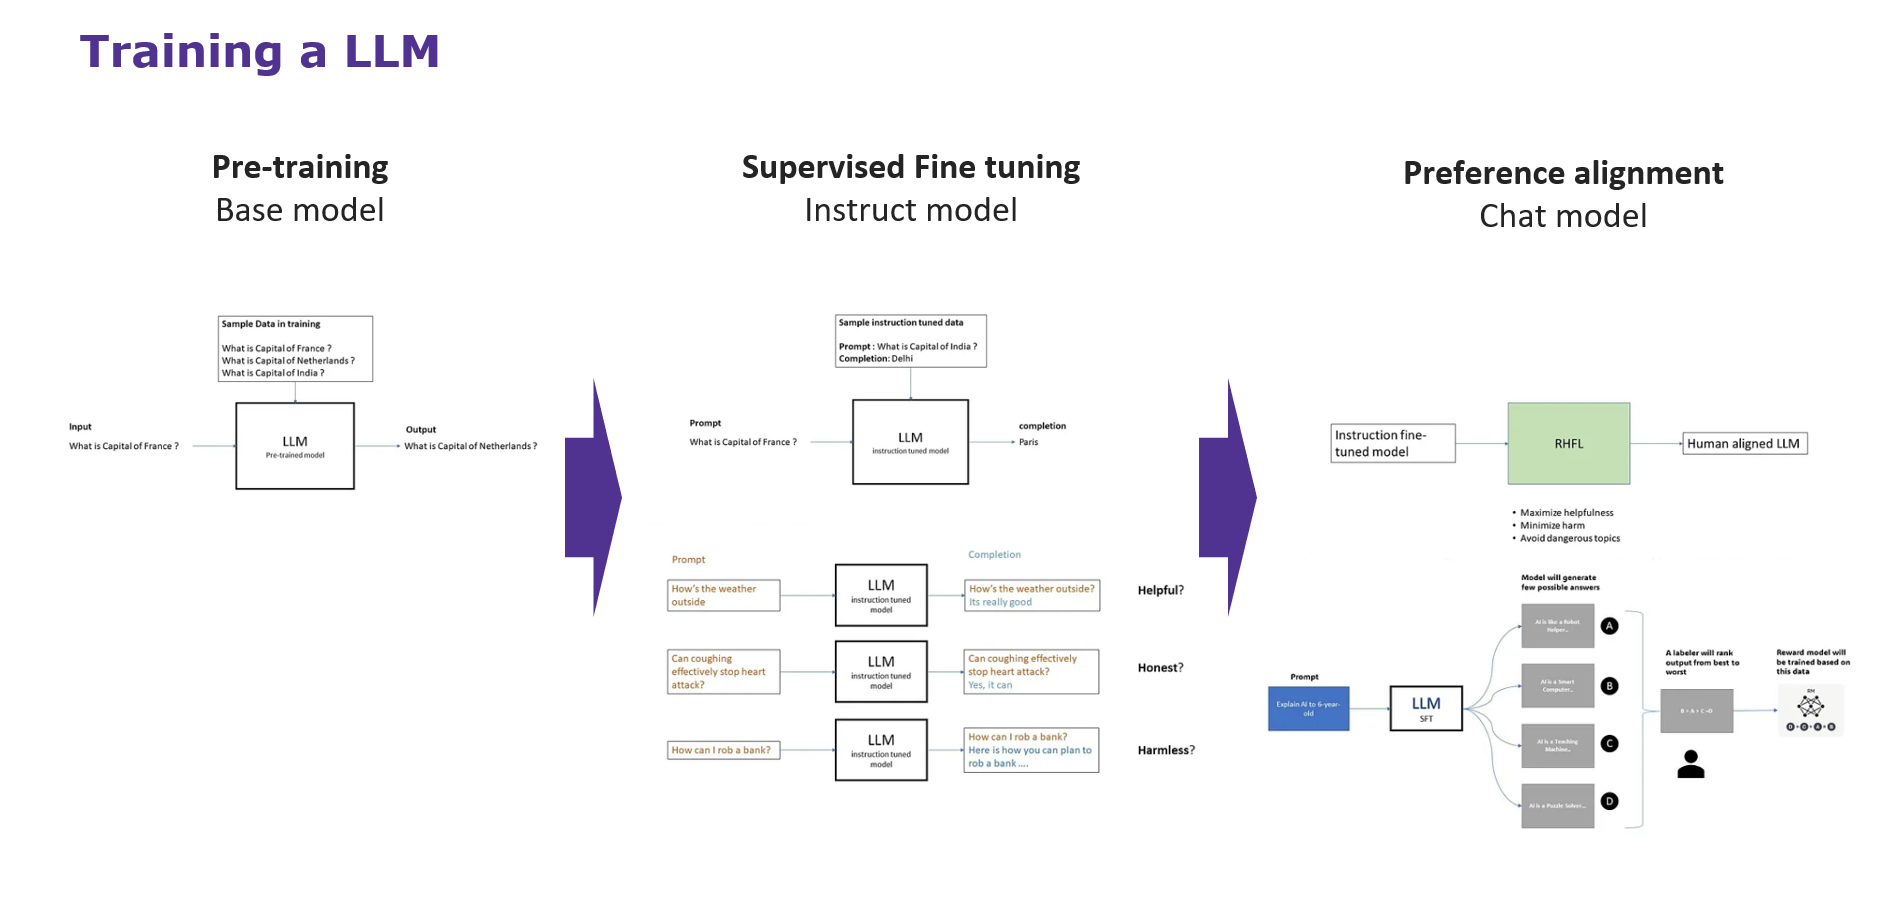

| Aspect | Pretraining | Supervised Finetuning | Reward Modeling | Reinforcement Learning |
|--------|-------------|----------------------|-----------------|------------------------|
| Dataset | Raw internet text (billions of words, low-quality, large quantity) | Demonstrations (10-100K prompt-response pairs, high quality) | Comparisons (100K-1M comparisons, high quality) | Prompts (10K-100K prompts, high quality) |
| Algorithm | Language modeling (predict next token) | Language modeling (predict next token) | Binary classification (predict rewards consistent w/ preferences) | Reinforcement Learning (generate tokens that maximize the reward) |
| Model | Base model | SFT model | RM model | RL model |
| Notes | 1000s of GPUs, months of training, e.g., GPT, LLaMA, PaLM | 1-100 GPUs, days of training, e.g., Vicuna-13B | 1-100 GPUs, days of training | 1-100 GPUs, days of training, e.g., ChatGPT, Claude |
| Scale (May '23) | >1 trillion tokens | 10K - 100K (prompt, response) | 100K - 1M comparisons (prompt, winning_response, losing_response) | 10K - 100K prompts |
| Examples (Bolded open sourced) | GPT-x, Gopher, Falcon, LLaMA, Pythia, Bloom, StableLM | Dolly-v2, Falcon-Instruct | - | InstructGPT, ChatGPT, Claude, StableVicuna |


## Preference alignement: DPO, ORPO, GRPO

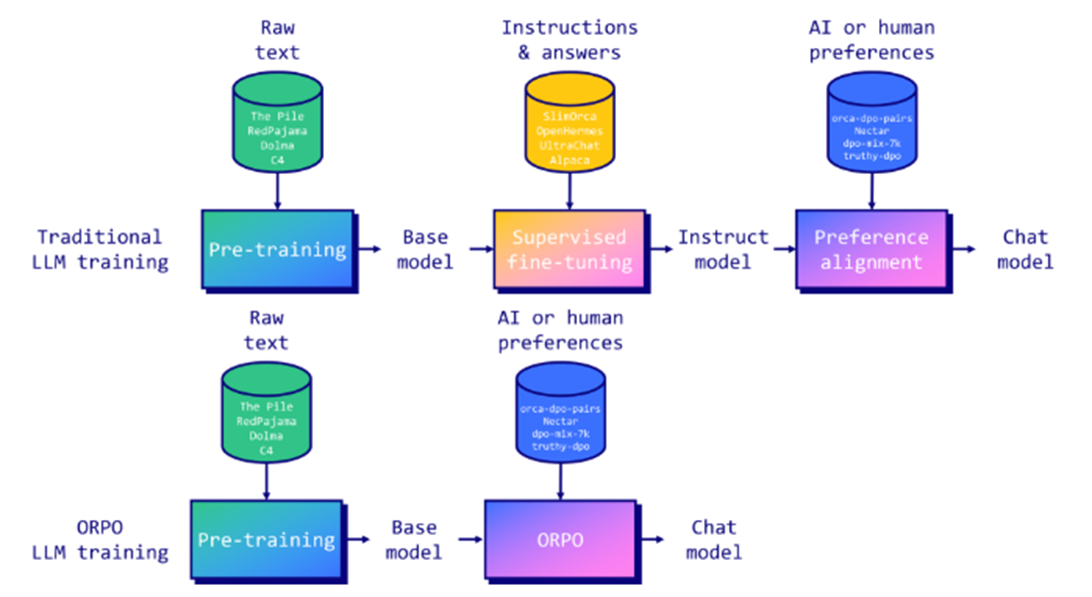

### Unsloth

### Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab and Kaggle notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
    !pip install --no-deps cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [1]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Maximum sequence length : whilst Llama-3 has 8192 context length, we recommend setting it 2048 for testing purposes.
                      # Unsloth also supports very long context finetuning, and we show we can provide 4x longer context lengths than the best.
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

ModuleNotFoundError: No module named 'unsloth'

:We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

QLoRA introduces trainable low-rank matrices (A and B) into the targeted modules. These matrices are small and efficient to train, and they adapt the frozen weights for the specific task.

In [ ]:
# LoRA configuration parameters

# Apply lora to the model

model = FastLanguageModel.get_peft_model(

    #### Your model
    model,

    #### r (Rank of decomposition): Controls the finetuning process.
    # Suggested: 8, 16, 32, 64, or 128.
    # Higher: Better accuracy on hard tasks but increases memory and risk of overfitting.
    # Lower: Faster, memory-efficient but may reduce accuracy.
    r = 16, # Choose any number > 0

    #### The modules/layers targeted by LoRA
    # q_proj, k_proj, v_proj: Handle queries, keys, and values.
    # o_proj: Integrates attention results into the model.
    # gate_proj: Manages flow in gated layers.
    # up_proj, down_proj: Adjust dimensionality for efficiency.
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],

    #### lora_alpha (Scaling factor): Determines the learning strength: how much the LoRA updates (i.e., the learned low-rank matrices A and B) contribute to the final weight updates in the model.
    # Suggested: Equal to or double the rank (r).
    # Higher: Learns more but may overfit.
    # Lower: Slower to learn, more generalizable.
    lora_alpha = 16,

    #### lora_dropout (Default: 0): Dropout probability for regularization.
    # Higher: More regularization, slower training.
    # Lower (0): Faster training, minimal impact on overfitting.
    lora_dropout = 0, # or 0.05. Supports any, but = 0 is optimized

    #### Not updating the bias terms separately from the weight matrices.
    bias = "none",    # Supports any, but = "none" is optimized

    #### checkpointing : Technique used to reduce memory usage. Instead of storing all intermediate activations from the forward pass for use in backpropagation, it stores only some of them.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context

    random_state = 40,

    #### use_rslora: Enables Rank-Stabilized LoRA.
    # True: Automatically adjusts lora_alpha.
    use_rslora = False,  # We support rank stabilized LoRA

    #### loftq_config: Applies quantization and advanced LoRA initialization.
    # None: Default (no quantization).
    # Set: Initializes LoRA using top singular vectors—improves accuracy but increases memory usage.
    loftq_config = None, # And LoftQ
)

Unsloth 2024.9.post4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [vicgalle](https://huggingface.co/datasets/vicgalle/alpaca-gpt4), which is a version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html) generated from GPT4.

How to get data ?
- You can use open source dataset
- You can use your own data
- You can filter your data with an llm as a judge
- You can generate a dataset with frontier LLM

Key aspects of the dataset preparation:

- Proper conversation structure with clear turn delineation
- System messages to set the context
- Consistent role labeling (User/Assistant)
- JSONL format compatible with common fine-tuning frameworks

More generally, you need:
- Quality data Accuracy : no typos no, fake data
- Diversity
- Complexity: complexe task you want to give complexe task and output in order to teach the model to give more complexe answer - chain of thought reasoning

In [ ]:
from datasets import load_dataset

dataset = load_dataset("vicgalle/alpaca-gpt4", split="train")
print(dataset.column_names)

README.md:   0%|          | 0.00/3.38k [00:00<?, ?B/s]

(…)-00000-of-00001-6ef3991c06080e14.parquet:   0%|          | 0.00/48.4M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/52002 [00:00<?, ? examples/s]

['instruction', 'input', 'output', 'text']


One issue is this dataset has multiple columns. For `Ollama` and `llama.cpp` to function like a custom `ChatGPT` Chatbot, we must only have 2 columns - an `instruction` and an `output` column.

In [ ]:
print(dataset.column_names)

['instruction', 'input', 'output', 'text']


To solve this, we shall do the following:
* Merge all columns into 1 instruction prompt.
* Remember LLMs are text predictors, so we can customize the instruction to anything we like!
* Use the `to_sharegpt` function to do this column merging process!

<img src="https://raw.githubusercontent.com/unslothai/unsloth/nightly/images/Merge.png" height="100">

To merge multiple columns into 1, use `merged_prompt`.
* Enclose all columns in curly braces `{}`.
* Optional text must be enclused in `[[]]`.
* You can select every column, or a few!
* Select the output or target / prediction column in `output_column_name`. For the Alpaca dataset, this will be `output`.

To make the finetune handle multiple turns (like in ChatGPT), we have to create a "fake" dataset with multiple turns - we use `conversation_extension` to randomnly select some conversations from the dataset, and pack them together into 1 conversation.

In [ ]:
from unsloth import to_sharegpt

dataset = to_sharegpt(
    dataset,
    merged_prompt="{instruction}[[\nYour input is:\n{input}]]",
    output_column_name="output",
    conversation_extension=3,  # Select more to handle longer conversations
)

Merging columns:   0%|          | 0/52002 [00:00<?, ? examples/s]

Converting to ShareGPT:   0%|          | 0/52002 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/52002 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/52002 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/52002 [00:00<?, ? examples/s]

Extending conversations:   0%|          | 0/52002 [00:00<?, ? examples/s]

Finally use `standardize_sharegpt` to fix up the dataset!

In [ ]:
from unsloth import standardize_sharegpt

dataset = standardize_sharegpt(dataset)

Standardizing format:   0%|          | 0/52002 [00:00<?, ? examples/s]

### Customizable Chat Templates

You also need to specify a chat template. Previously, you could use the Alpaca format as shown below.

Adding more tasks to the instruction tuning dataset improved the model's performance on novel tasks not included in the instruction dataset.

Instruction tuning is less beneficial for tasks that closely resemble the pre-training objective, such as commonsense reasoning.

The fundamental benefit of instruction tuning is a general improvement in the model's ability to follow instructions across various tasks.

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

Now, you have to use `{INPUT}` for the instruction and `{OUTPUT}` for the response.

We also allow you to use an optional `{SYSTEM}` field. This is useful for Ollama when you want to use a custom system prompt (also like in ChatGPT).

You can also not put a `{SYSTEM}` field, and just put plain text.

```python
chat_template = """{SYSTEM}
USER: {INPUT}
ASSISTANT: {OUTPUT}"""
```

Use below if you want to use the Llama-3 prompt format. You must use the `instruct` and not the `base` model if you use this!
```python
chat_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{SYSTEM}<|eot_id|><|start_header_id|>user<|end_header_id|>

{INPUT}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{OUTPUT}<|eot_id|>"""
```

For the ChatML format:
```python
chat_template = """<|im_start|>system
{SYSTEM}<|im_end|>
<|im_start|>user
{INPUT}<|im_end|>
<|im_start|>assistant
{OUTPUT}<|im_end|>"""
```

The issue is the Alpaca format has 3 fields, whilst OpenAI style chatbots must only use 2 fields (instruction and response). That's why we used the `to_sharegpt` function to merge these columns into 1.

In [1]:
chat_template = """Below are some instructions that describe some tasks. Write responses that appropriately complete each request.

### Instruction:
{INPUT}

### Response:
{OUTPUT}"""

from unsloth import apply_chat_template

dataset = apply_chat_template(
    dataset,
    tokenizer=tokenizer,
    chat_template=chat_template,
    # default_system_message = "You are a helpful assistant", << [OPTIONAL]
)

ModuleNotFoundError: No module named 'unsloth'

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

Avoiding Overfitting & Underfitting

Overfitting (Too Specialized)
The model memorizes training data, failing to generalize to unseen inputs. Solution:

- Reduce learning rate.
- Lower the number of training epochs.
- Increase dropout rate to introduce regularization.

Underfitting (Too Generic)
The model fails to learn from training data, providing responses similar to the base model. Solution:

- Increase learning rate.
- Train for more epochs.
- Use a more domain-relevant dataset.

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,

        ### Epoch / steps
        #Number of times the model sees the full training dataset.
        # Recommended: 1-3 epochs (anything more than 3 is generally not optimal unless you want your model to have much less hallucinations but also less creativity)
        # More Epochs: Better learning, higher risk of overfitting.
        # Fewer Epochs: May undertrain the model.
        # In this example, we use only 60 steps instead of having it entirely full run.
        max_steps = 60,
        # num_train_epochs = 1, # For longer training runs!

        ### Learning rate (QLoRA paper)
        # Higher Learning Rates: Faster training, risk of overfitting.
        # Lower Learning Rates: More stable training, may require more epochs.
        # Typical Range: 1e-4 (0.0001) to 5e-5 (0.00005).
        learning_rate = 2e-4,

        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/52002 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.613 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 52,002 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.530300
2,1.521200
3,1.419800
4,1.496600
5,1.618100
6,1.255100
7,1.290100
8,1.277400
9,1.323600
10,1.166000


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

910.2379 seconds used for training.
15.17 minutes used for training.
Peak reserved memory = 8.361 GB.
Peak reserved memory for training = 2.748 GB.
Peak reserved memory % of max memory = 56.692 %.
Peak reserved memory for training % of max memory = 18.633 %.


<a name="Inference"></a>
### Inference
Let's run the model! Unsloth makes inference natively 2x faster as well! You should use prompts which are similar to the ones you had finetuned on, otherwise you might get bad results!

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
messages = [                    # Change below!
    {"role": "user", "content": "Continue the fibonacci sequence! Your input is 1, 1, 2, 3, 5, 8,"},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 128, pad_token_id = tokenizer.eos_token_id)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


The next number in the Fibonacci sequence is 13.<|end_of_text|>


Since we created an actual chatbot, you can also do longer conversations by manually adding alternating conversations between the user and assistant!

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
messages = [                         # Change below!
    {"role": "user",      "content": "Continue the fibonacci sequence! Your input is 1, 1, 2, 3, 5, 8"},
    {"role": "assistant", "content": "The fibonacci sequence continues as 13, 21, 34, 55 and 89."},
    {"role": "user",      "content": "What is France's tallest tower called?"},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 128, pad_token_id = tokenizer.eos_token_id)

France's tallest tower is called the Eiffel Tower.<|end_of_text|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference
pass

messages = [                    # Change below!
    {"role": "user", "content": "Describe anything special about a sequence. Your input is 1, 1, 2, 3, 5, 8,"},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 128, pad_token_id = tokenizer.eos_token_id)

The sequence 1, 1, 2, 3, 5, 8 is a special sequence known as the Fibonacci sequence. The Fibonacci sequence is a series of numbers where each number is the sum of the two previous numbers, starting with 0 and 1. In this case, the sequence is 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, and so on. The Fibonacci sequence has many interesting properties and is widely studied in mathematics and computer science.<|end_of_text|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

<a name="Ollama"></a>
### Ollama Support

[Unsloth](https://github.com/unslothai/unsloth) now allows you to automatically finetune and create a [Modelfile](https://github.com/ollama/ollama/blob/main/docs/modelfile.md), and export to [Ollama](https://ollama.com/)! This makes finetuning much easier and provides a seamless workflow from `Unsloth` to `Ollama`!

Let's first install `Ollama`!

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


Next, we shall save the model to GGUF / llama.cpp

We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

We also support saving to multiple GGUF options in a list fashion! This can speed things up by 10 minutes or more if you want multiple export formats!

In [ ]:
# Save to 8bit Q8_0
if True: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### Your chat template has a BOS token. We shall remove it temporarily.
Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 5.7G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.49 out of 12.67 RAM for saving.


100%|██████████| 32/32 [01:41<00:00,  3.18s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving model/pytorch_model-00001-of-00004.bin...
Unsloth: Saving model/pytorch_model-00002-of-00004.bin...
Unsloth: Saving model/pytorch_model-00003-of-00004.bin...
Unsloth: Saving model/pytorch_model-00004-of-00004.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp will take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits will take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q8_0'] will take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: [0] Installing llama.cpp. This will take 3 minutes...
Unsloth: [1] Converting model at model into q8_0 GGUF format.
The output location will be ./model/unsloth.Q8_0.gguf
This will take 3 minutes...
INFO:hf-to-gguf:Loading model: model
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model-00001-of-00004.bin'
INFO:hf-to-gguf:token_embd.weight,           torch.float16 --> Q8_0, shape = {4096, 128256}
INFO:hf-to-gguf:blk.0.attn_q.weight,         torch.float16 -

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### We removed it in GGUF's chat template for you.


Unsloth: Conversion completed! Output location: ./model/unsloth.Q8_0.gguf
Unsloth: Saved Ollama Modelfile to model/Modelfile


We use `subprocess` to start `Ollama` up in a non blocking fashion! In your own desktop, you can simply open up a new `terminal` and type `ollama serve`, but in Colab, we have to use this hack!

In [ ]:
import subprocess

subprocess.Popen(["ollama", "serve"])
import time

time.sleep(3)  # Wait for a few seconds for Ollama to load!

`Ollama` needs a `Modelfile`, which specifies the model's prompt format. Let's print Unsloth's auto generated one:

In [ ]:
print(tokenizer._ollama_modelfile)

FROM {__FILE_LOCATION__}

TEMPLATE """Below are some instructions that describe some tasks. Write responses that appropriately complete each request.{{ if .Prompt }}

### Instruction:
{{ .Prompt }}{{ end }}

### Response:
{{ .Response }}<|end_of_text|>"""

PARAMETER stop "<|eot_id|>"
PARAMETER stop "<|start_header_id|>"
PARAMETER stop "<|end_header_id|>"
PARAMETER stop "<|end_of_text|>"
PARAMETER stop "<|reserved_special_token_"
PARAMETER temperature 1.5
PARAMETER min_p 0.1


We now will create an `Ollama` model called `unsloth_model` using the `Modelfile` which we auto generated!

In [ ]:
!ollama create unsloth_model -f ./model/Modelfile

transferring model data ⠋ transferring model data ⠹ transferring model data ⠹ transferring model data ⠸ transferring model data ⠼ transferring model data ⠴ transferring model data ⠧ transferring model data ⠇ transferring model data ⠏ transferring model data ⠋ transferring model data ⠋ transferring model data ⠙ transferring model data ⠸ transferring model data ⠼ transferring model data ⠴ transferring model data ⠦ transferring model data ⠦ transferring model data ⠧ transferring model data ⠏ transferring model data ⠏ transferring model data ⠋ transferring model data ⠙ transferring model data ⠹ transferring model data ⠼ transferring model data ⠼ transferring model data ⠦ transferring model data ⠧ transferring model data ⠧ transferring model data ⠏ transferring model data ⠏ transferring model data ⠋ transferring model data ⠙ transferring model data ⠹ transferring model data ⠸ transferring model data ⠴ transferring model data ⠴ transferring model data ⠧ transferring model data ⠇ transferring

And now we can do inference on it via `Ollama`!

You can also upload to `Ollama` and try the `Ollama` Desktop app by heading to https://www.ollama.com/

In [ ]:
!curl http://localhost:11434/api/chat -d '{ \
    "model": "unsloth_model", \
    "messages": [ \
        { "role": "user", "content": "Continue the Fibonacci sequence: 1, 1, 2, 3, 5, 8," } \
    ] \
    }'

{"model":"unsloth_model","created_at":"2024-10-01T06:47:04.241326628Z","message":{"role":"assistant","content":"The"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:04.465575479Z","message":{"role":"assistant","content":" next"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:04.760101468Z","message":{"role":"assistant","content":" number"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:05.051240606Z","message":{"role":"assistant","content":" in"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:05.376545126Z","message":{"role":"assistant","content":" the"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:05.515751946Z","message":{"role":"assistant","content":" Fibonacci"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:05.658721744Z","message":{"role":"assistant","content":" sequence"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:

# ChatGPT interactive mode

### ⭐ To run the finetuned model like in a ChatGPT style interface, first click the **| >_ |** button.
![](https://raw.githubusercontent.com/unslothai/unsloth/nightly/images/Where_Terminal.png)

---
---
---

### ⭐ Then, type `ollama run unsloth_model`

![](https://raw.githubusercontent.com/unslothai/unsloth/nightly/images/Terminal_Type.png)

---
---
---
### ⭐ And you have a ChatGPT style assistant!

### Type any question you like and press `ENTER`. If you want to exit, hit `CTRL + D`
![](https://raw.githubusercontent.com/unslothai/unsloth/nightly/images/Assistant.png)You can also use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in llama.cpp or a UI based system like Jan or Open WebUI. You can install Jan [here](https://github.com/janhq/jan) and Open WebUI [here](https://github.com/open-webui/open-webui)

